# Data pre-processing of Tirosh et al (2016) Jerby-Arnon et al (2018) Patient Melanoma Single-Cell Data for SCENIC Analysis

Nov, 2021


Jerby-Arnon L et al. A Cancer Cell Program Promotes T Cell Exclusion and Resistance to Checkpoint Blockade. Cell 2018 https://dx.doi.org/10.1016/j.cell.2018.09.006

Tirosh et al. Dissecting the multicellular ecosystem of metastatic melanoma by single-cell RNA-seq. Science 2016 https://doi.org/10.1126/science.aad0501

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp


In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = '/~/20211116_JerbyArnon_Tirosh/pre-processing'
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "jerby-arnon_sc_skin_unfiltered.loom" 

# path to loom files with basic filtering applied for SCENIC Analysis (this will be created in the "initial filtering" step below).
f_loom_path_filt_scenic = "jerby-arnon_sc_skin_filtered_for_scenic.loom" #log2(TPM/10 +1)

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata.h5ad"
f_anndata_mal_path = "anndata_mal.h5ad"

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=300, fontsize=14, dpi_save=600,figsize= (6,5))
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [4]:
data = pd.read_csv('/Volumes/GoogleDrive/My Drive/Fallahi Lab/AP-1 Project/Tirosh et al Data Analysis/Data/GSE115978/Tirosh_JerbyArnon_Merged_TPM_with_annotation_MAL.csv')
data.drop(columns = 'Unnamed: 0',inplace=True)
data

,cell_id,tumor,cell.types,treatment.group,cohort,no.of.genes,no.of.reads,C9orf152,RPS11,ELMO2,...,GPLD1,SNORD115-39,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
0,cy102_CD45neg_CD90neg_S1,Mel102,Mal,post.treatment,New,10026,759447,0.107018,7.014277,3.495056,...,1.650765,0,2.951215,0.0,2.770195,2.160598,5.060393,1.753177,3.357130,0.0
1,cy102_CD45neg_CD90neg_S11,Mel102,Mal,post.treatment,New,7853,675977,0.000000,7.693954,0.000000,...,0.454176,0,3.172808,0.0,0.000000,0.000000,6.359170,3.222495,4.772941,0.0
2,cy102_CD45neg_CD90neg_S13,Mel102,Mal,post.treatment,New,3315,309067,0.283329,0.000000,0.000000,...,0.710173,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.158175,0.0
3,cy102_CD45neg_CD90neg_S14,Mel102,Mal,post.treatment,New,7103,752226,0.000000,5.977486,2.562670,...,0.608809,0,2.387914,0.0,2.832080,0.000000,5.388809,0.000000,4.398419,0.0
4,cy102_CD45neg_CD90neg_S15,Mel102,Mal,post.treatment,New,3611,520036,0.000000,0.000000,0.000000,...,0.468844,0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.946310,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,Cy59_90,Mel59,Mal,treatment.naive,Tirosh,0,0,0.000000,8.809900,0.000000,...,0.000000,0,2.231400,0.0,2.789100,0.000000,5.175800,3.295400,4.474800,0.0
2068,Cy59_92,Mel59,Mal,treatment.naive,Tirosh,0,0,0.000000,8.350700,0.000000,...,0.000000,0,0.000000,0.0,0.000000,0.000000,6.391600,3.449300,4.038000,0.0
2069,Cy59_93,Mel59,Mal,treatment.naive,Tirosh,0,0,0.000000,8.849400,5.040500,...,0.000000,0,0.000000,0.0,4.388500,0.000000,6.517500,0.000000,3.154300,0.0
2070,Cy59_94,Mel59,Mal,treatment.naive,Tirosh,0,0,0.000000,8.611100,0.000000,...,0.000000,0,3.489900,0.0,0.000000,2.493600,0.000000,0.000000,1.551400,0.0


In [6]:
#Create AnnData for scanpy

adata = sc.AnnData(data.drop(columns = obs))
for i in obs:
    adata.obs[i] = data[i].to_numpy() #observation annotation

# simply compute the number of genes per cell (computers 'n_genes' column)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)  #sum of log2TPM count
adata.obs['n_genes'] = np.array( np.sum(adata.X>0 , axis=1)).flatten()
    

/opt/anaconda3/envs/scenic_protocol/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/opt/anaconda3/envs/scenic_protocol/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
adata

AnnData object with n_obs × n_vars = 2072 × 23686
    obs: 'cell_id', 'tumor', 'cell.types', 'treatment.group', 'cohort', 'no.of.genes', 'no.of.reads', 'percent_mito', 'n_counts', 'n_genes'

## Quality control and filtering

In [8]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

... storing 'tumor' as categorical
... storing 'cell.types' as categorical
... storing 'treatment.group' as categorical
... storing 'cohort' as categorical


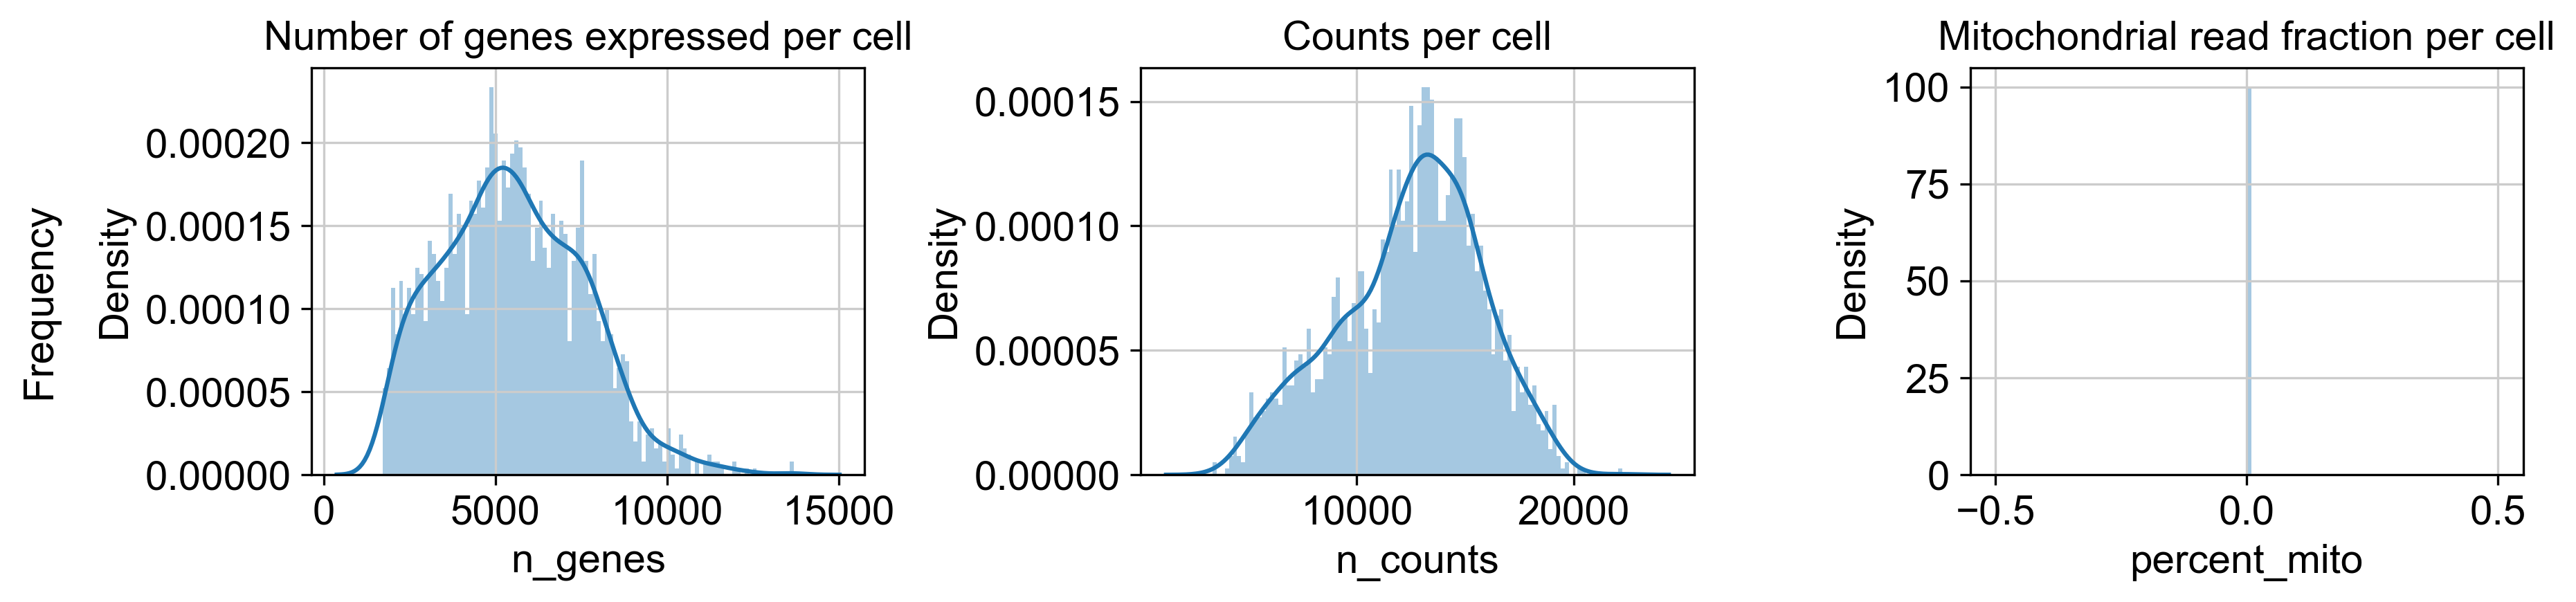

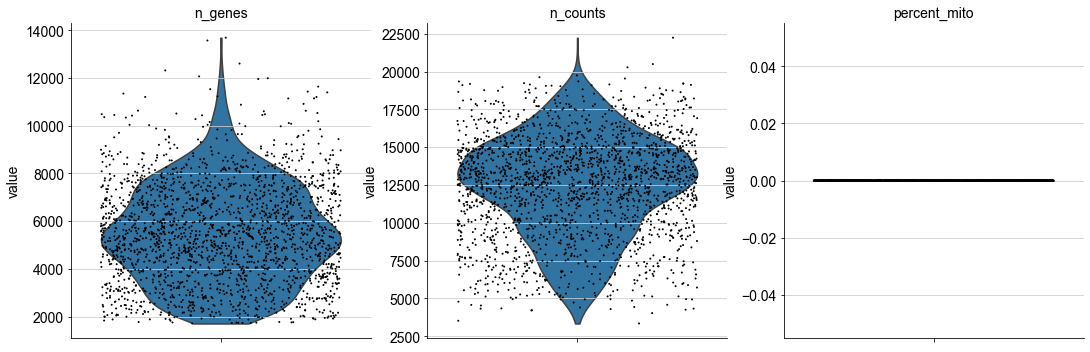

In [9]:

%matplotlib inline
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), dpi=300, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=300, bbox_inches='tight')


sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True ,size=2)

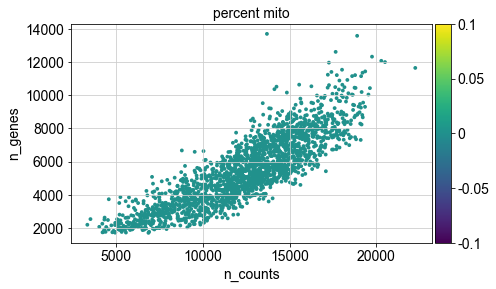

In [10]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### Filter cells
* number of genes per cell: __>1700__ (as in Tirosh et al 2016)

### Filter genes
* min number of cells detected for each gene: __1% cells__
* min count for each gene: __5 logged TPM count in 1% cells__ (as in Aibar et al 2017)
* max fraction of mito genes: __20%__

In [11]:
adata_f = adata

# initial cuts
sc.pp.filter_cells(adata_f, min_genes=1700)

min_cells = np.round(adata_f.n_obs*0.01)
min_counts = 5*adata_f.n_obs*0.01
sc.pp.filter_genes(adata_f, min_cells=min_cells)
sc.pp.filter_genes(adata_f, min_counts = min_counts)
adata_f = adata_f[adata_f.obs['percent_mito'] < 0.2, :]

/opt/anaconda3/envs/scenic_protocol/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 5983 genes that are detected in less than 21.0 cells
filtered out 3014 genes that are detected in less than 103.60000000000001 counts
/opt/anaconda3/envs/scenic_protocol/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
adata_f

View of AnnData object with n_obs × n_vars = 2072 × 14689
    obs: 'cell_id', 'tumor', 'cell.types', 'treatment.group', 'cohort', 'no.of.genes', 'no.of.reads', 'percent_mito', 'n_counts', 'n_genes'
    var: 'n_cells', 'n_counts'

## Save data

In [13]:
#scanpy data
adata.write( f_anndata_path ) #full organized data
adata_f.write( f_anndata_mal_path ) #filtered organized data

#loom file before filter
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "Tumor": np.array(adata.obs['tumor']) ,
    "nGenes": np.array(adata.obs['n_genes']) ,
    "nCounts": np.array(adata.obs['n_counts'])
}
lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs)

#loom file after filter (for scenic)
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata_f.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata_f.obs_names) ,
    "Tumor": np.array(adata_f.obs['tumor']) ,
    "nGenes": np.array(adata_f.obs['n_genes']) ,
    "nCounts": np.array(adata_f.obs['n_counts'])
}
lp.create( f_loom_path_filt_scenic, adata_f.X.transpose(), row_attrs, col_attrs)